In [1]:
from cil.optimisation.operators import BlurringOperator, GradientOperator, BlockOperator
from cil.optimisation.functions import LeastSquares, L2NormSquared, BlockFunction, IndicatorBox
from cil.optimisation.algorithms import FISTA, PDHG
from cil.utilities import dataexample, noise
from cil.utilities.display import show2D
import numpy as np
import matplotlib.pyplot as plt
import zarr
from MixedL21Norm_fix import MixedL21Norm_fix
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['font.size'] = 20

### Load data

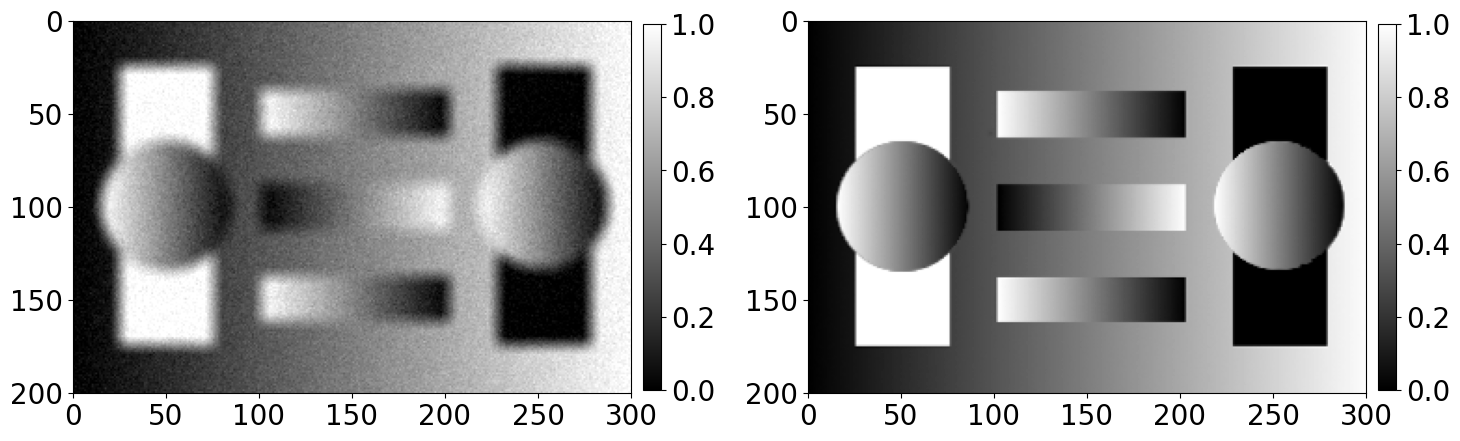

In [2]:
# # Load data
data = dataexample.SHAPES.get()
ig = data.geometry

# Parameters for point spread function PSF (size and std)
ks          = 10; 
ksigma      = 5;

# Create 1D PSF and 2D as outer product, then normalise.
w           = np.exp(-np.arange(-(ks-1)/2,(ks-1)/2+1)**2/(2*ksigma**2))
w.shape     = (ks,1)
PSF         = w*np.transpose(w)
PSF         = PSF/(PSF**2).sum()
PSF         = PSF/PSF.sum()


seed = 10
var = 0.001

# Create blurring operator and apply to clean image to produce blurred and display.
BOP = BlurringOperator(PSF,ig)
blurred_noisy = noise.gaussian(BOP.direct(data), seed = seed, var = var, clip=True)
show2D([blurred_noisy.array, data.array], origin="upper")



### Save to zarr

In [3]:
dd = zarr.open_group("results/noisy_blurry_shapes_var_{}_seed_{}.zarr".format(var, seed))
dd["blurred_noisy"] = blurred_noisy.array

### Solve TV deblurring with PDHG (precond)

In [4]:
alpha = 0.025
initial = ig.allocate(0.)

In [5]:
A = BOP
f1 = 0.5 * L2NormSquared(b=blurred_noisy)
f2 = alpha * MixedL21Norm_fix()
F = BlockFunction(f1, f2)
Grad = GradientOperator(ig)
K = BlockOperator(A, Grad)
G = IndicatorBox(lower=0)
normK = K.norm()

tmp_sigma = K.range_geometry().allocate()
tmp_sigma.get_item(0).fill(A.direct(A.domain_geometry().allocate(1)))
tmp_sigma.get_item(1).get_item(0).fill(Grad.domain_geometry().allocate(2))
tmp_sigma.get_item(1).get_item(1).fill(Grad.domain_geometry().allocate(2))
sigma = 1./tmp_sigma

tmp_tau = K.domain_geometry().allocate()
tmp_tau.fill(A.adjoint(A.range_geometry().allocate(1))
             + Grad.domain_geometry().allocate(2) + Grad.domain_geometry().allocate(2))
tau = 1./tmp_tau

pdhg_optimal = PDHG(initial = initial, f=F, g=G, operator=K, sigma=sigma, tau=tau,
            max_iteration = 200000,
            update_objective_interval=5000)    
pdhg_optimal.run(verbose=1)


/Users/evangelospapoutsellis/anaconda3/envs/cil_231_m2_py39/lib/python3.9/site-packages/cil/optimisation/algorithms/PDHG.py:414: UserWarning: Convergence criterion can only be checked for scalar values of tau and sigma.
  warnings.warn("Convergence criterion can only be checked for scalar values of tau and sigma.")
/Users/evangelospapoutsellis/anaconda3/envs/cil_231_m2_py39/lib/python3.9/site-packages/cil/framework/framework.py:2820: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


     Iter   Max Iter  Time(s)/Iter            Objective
        0     200000         0.000          9.94850e+03
     5000     200000         0.012          5.56310e+01
    10000     200000         0.012          5.56310e+01
    15000     200000         0.012          5.56310e+01
    20000     200000         0.012          5.56310e+01
    25000     200000         0.012          5.56310e+01
    30000     200000         0.012          5.56310e+01
    35000     200000         0.012          5.56310e+01
    40000     200000         0.012          5.56310e+01
    45000     200000         0.012          5.56310e+01
    50000     200000         0.012          5.56310e+01
    55000     200000         0.012          5.56310e+01
    60000     200000         0.012          5.56310e+01
    65000     200000         0.012          5.56310e+01
    70000     200000         0.012          5.56310e+01
    75000     200000         0.012          5.56310e+01
    80000     200000         0.012          5.56

In [6]:
dd = zarr.open_group("results/pdhg_optimal_precond_shapes_tv_alpha_{}.zarr".format(alpha))
dd["solution"] = pdhg_optimal.solution.array
dd["objective"] = pdhg_optimal.objective

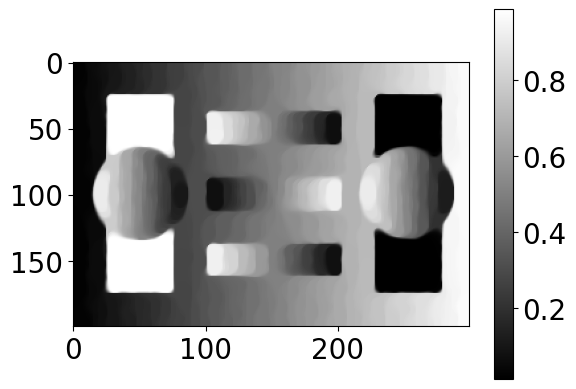

In [7]:
plt.imshow(pdhg_optimal.solution.array, cmap="gray")
plt.colorbar()